АНАЛИЗ ДАННЫХ ГРИБОВ С АВТОЭНКОДЕРОМ И T-SNE
Создание демонстрационных данных...
Демонстрационные данные созданы!

Размер датасета: (2000, 23)
Первые 5 строк данных:
       class cap-shape cap-surface cap-color bruises odor gill-attachment  \
0     edible         a           y         o       a    x               p   
1  poisonous         c           z         p       a    z               m   
2  poisonous         c           x         p       c    z               n   
3     edible         a           y         n       a    x               n   
4     edible         a           x         m       a    x               o   

  gill-spacing gill-size gill-color  ... stalk-surface-below-ring  \
0            b         y          n  ...                        a   
1            a         y          o  ...                        a   
2            c         y          n  ...                        b   
3            a         z          n  ...                        a   
4            a         z  

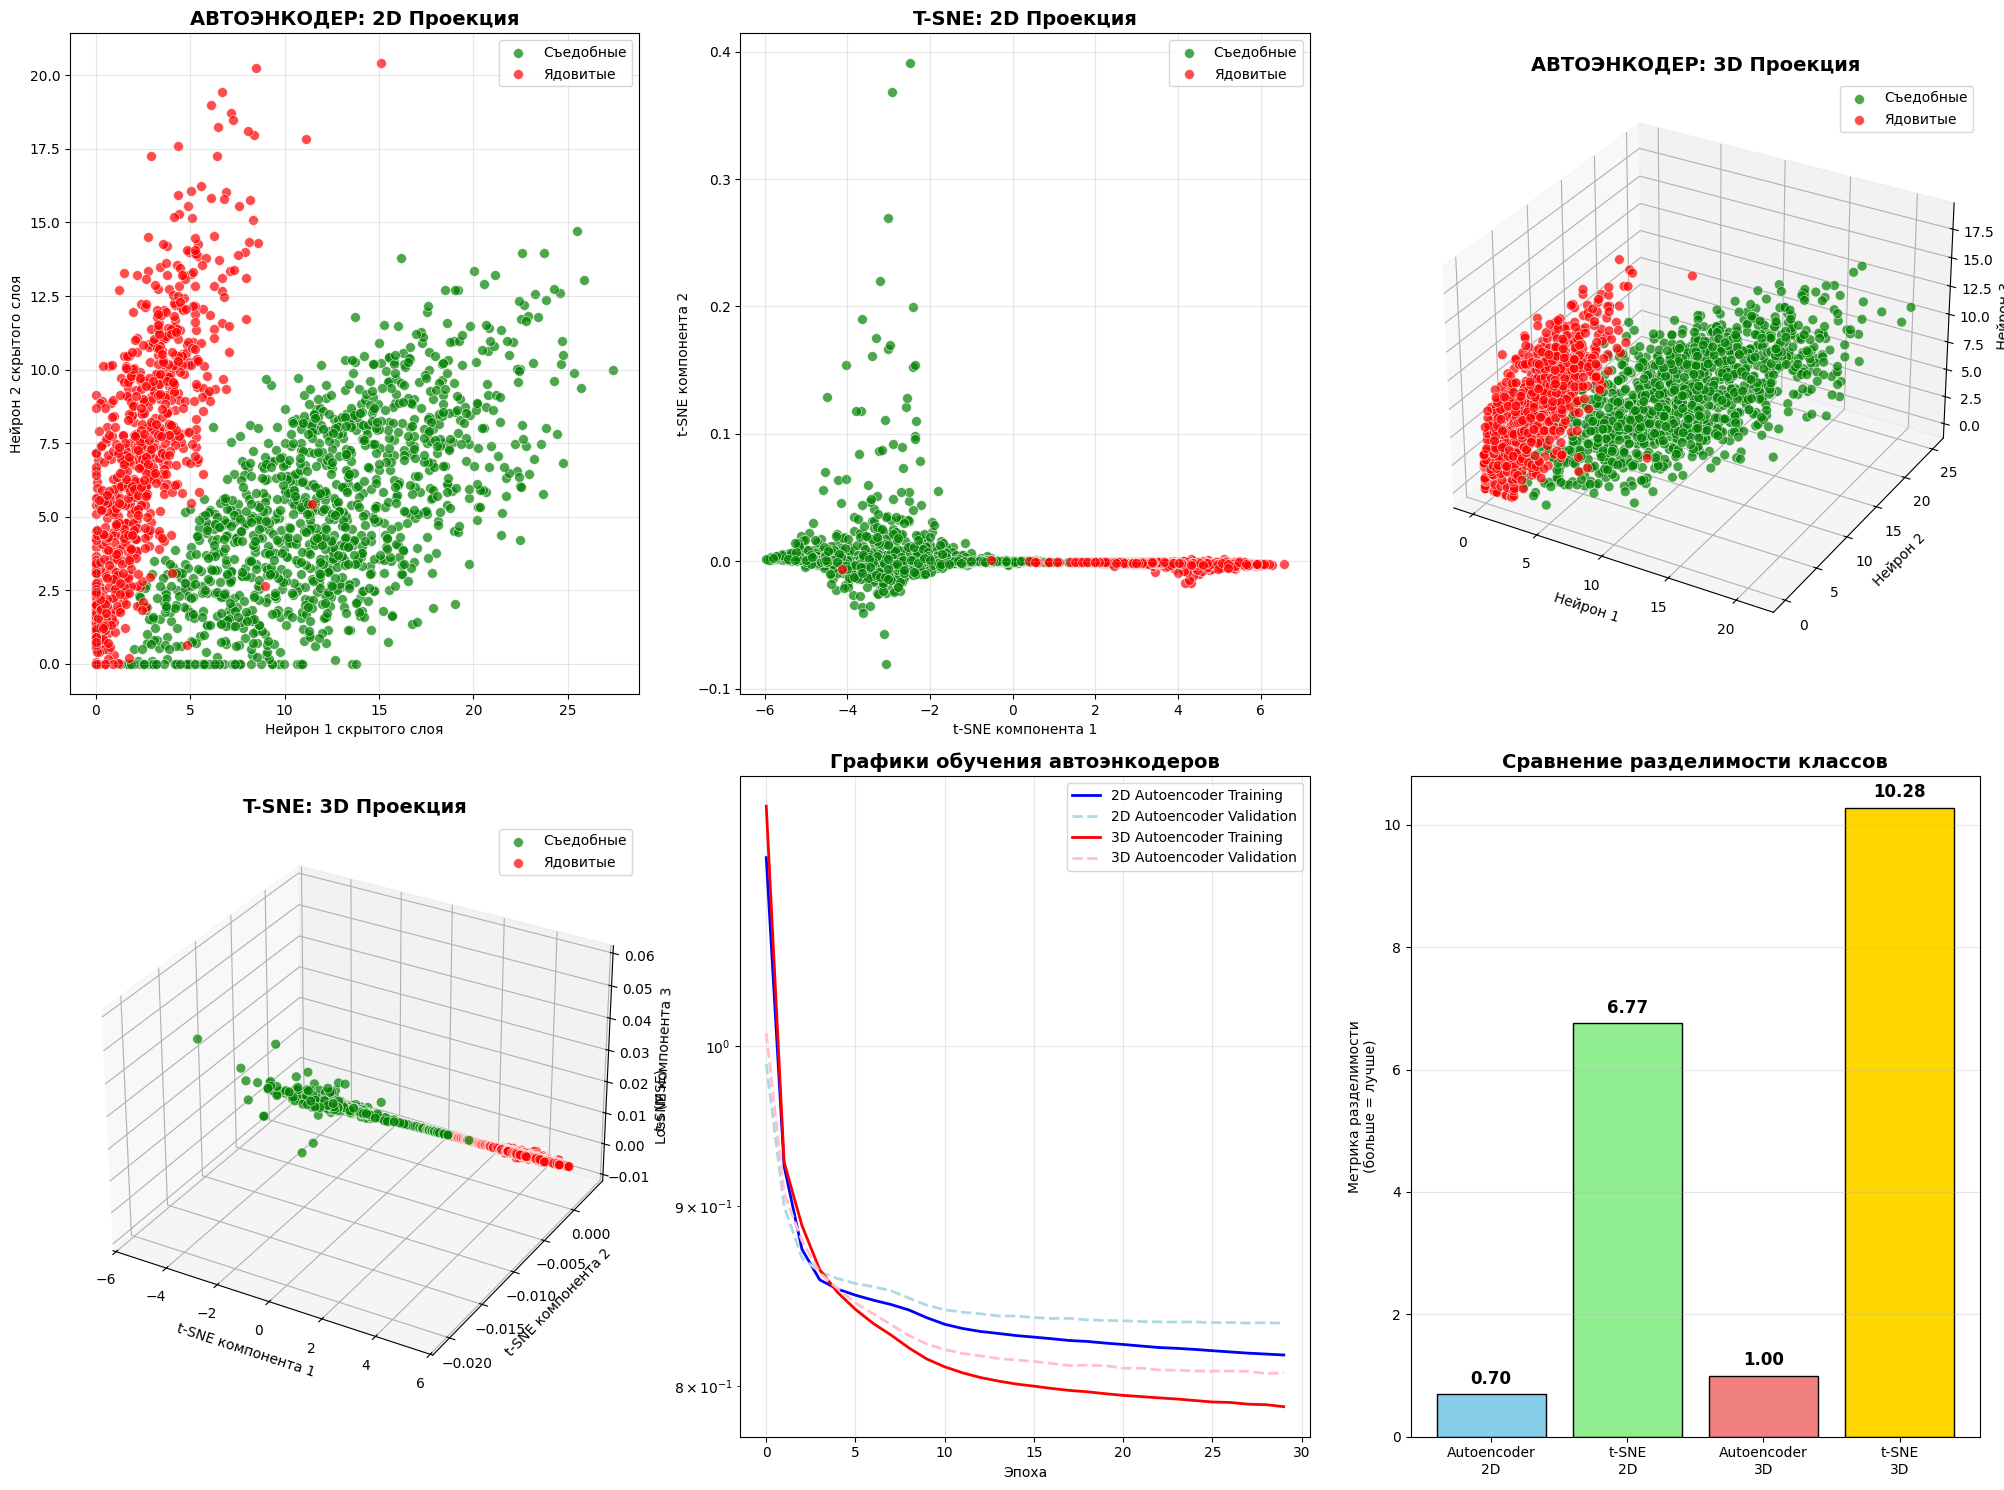


СТАТИСТИЧЕСКИЙ АНАЛИЗ ПРОЕКЦИЙ

Autoencoder 2D:
  Компонента 1:
    Съедобные: μ=12.060, σ=5.071
    Ядовитые:  μ=2.501, σ=2.008
    t-тест: p-value = 0.000000 ***
  Компонента 2:
    Съедобные: μ=5.131, σ=3.051
    Ядовитые:  μ=6.991, σ=4.036
    t-тест: p-value = 0.000000 ***

Autoencoder 3D:
  Компонента 1:
    Съедобные: μ=9.748, σ=4.010
    Ядовитые:  μ=2.852, σ=2.178
    t-тест: p-value = 0.000000 ***
  Компонента 2:
    Съедобные: μ=11.225, σ=4.266
    Ядовитые:  μ=2.424, σ=1.907
    t-тест: p-value = 0.000000 ***
  Компонента 3:
    Съедобные: μ=6.055, σ=3.125
    Ядовитые:  μ=7.144, σ=3.879
    t-тест: p-value = 0.000000 ***

t-SNE 2D:
  Компонента 1:
    Съедобные: μ=-2.668, σ=1.576
    Ядовитые:  μ=4.004, σ=1.208
    t-тест: p-value = 0.000000 ***
  Компонента 2:
    Съедобные: μ=0.005, σ=0.028
    Ядовитые:  μ=-0.002, σ=0.002
    t-тест: p-value = 0.000000 ***

t-SNE 3D:
  Компонента 1:
    Съедобные: μ=-2.229, σ=1.427
    Ядовитые:  μ=3.235, σ=1.074
    t-тест: p-value = 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print("=" * 60)
print("АНАЛИЗ ДАННЫХ ГРИБОВ С АВТОЭНКОДЕРОМ И T-SNE")
print("=" * 60)

print("Создание демонстрационных данных...")
np.random.seed(42)
n_samples = 2000

columns = [
    'class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
    'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
    'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring',
    'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color',
    'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat'
]

data = {
    'class': np.random.choice(['edible', 'poisonous'], n_samples, p=[0.6, 0.4]),
}

for i, col in enumerate(columns[1:]):
    if i % 3 == 0:
        data[col] = np.where(data['class'] == 'edible',
                            np.random.choice(['a', 'b', 'c'], n_samples, p=[0.7, 0.2, 0.1]),
                            np.random.choice(['a', 'b', 'c'], n_samples, p=[0.1, 0.2, 0.7]))
    elif i % 3 == 1:
        data[col] = np.where(data['class'] == 'edible',
                            np.random.choice(['x', 'y', 'z'], n_samples, p=[0.6, 0.3, 0.1]),
                            np.random.choice(['x', 'y', 'z'], n_samples, p=[0.2, 0.4, 0.4]))
    else:
        data[col] = np.random.choice(['m', 'n', 'o', 'p'], n_samples)

data = pd.DataFrame(data)
print("Демонстрационные данные созданы!")

print(f"\nРазмер датасета: {data.shape}")
print(f"Первые 5 строк данных:")
print(data.head())

print("\nПропущенные значения:")
print(data.isnull().sum())

print(f"\nРаспределение классов:")
print(data['class'].value_counts())

X = data.drop('class', axis=1)
y = data['class']

print(f"\nКоличество признаков: {len(X.columns)}")
print("Признаки:", X.columns.tolist())

label_encoders = {}
X_encoded = X.copy()

print("\nКодирование категориальных признаков...")
for column in X.columns:
    le = LabelEncoder()
    X_encoded[column] = le.fit_transform(X[column].astype(str))
    label_encoders[column] = le
    print(f"  {column}: {len(le.classes_)} категорий → {list(le.classes_)}")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

print(f"\nРазмерность после обработки: {X_scaled.shape}")

def build_autoencoder(input_dim, encoding_dim, hidden_dim=64):
    """Строит автоэнкодер с заданной размерностью скрытого слоя"""
    input_layer = Input(shape=(input_dim,))

    encoded = Dense(hidden_dim, activation='relu')(input_layer)
    encoded = Dense(encoding_dim, activation='relu', name='bottleneck')(encoded)

    decoded = Dense(hidden_dim, activation='relu')(encoded)
    decoded = Dense(input_dim, activation='sigmoid')(decoded)

    autoencoder = Model(input_layer, decoded)
    encoder = Model(input_layer, encoded)

    autoencoder.compile(optimizer=Adam(learning_rate=0.001),
                       loss='mse',
                       metrics=['mae'])

    return autoencoder, encoder

input_dim = X_scaled.shape[1]
encoding_dim_2d = 2
encoding_dim_3d = 3

print(f"\nПараметры автоэнкодера:")
print(f"  Входная размерность: {input_dim}")
print(f"  Размерность скрытого слоя (2D): {encoding_dim_2d}")
print(f"  Размерность скрытого слоя (3D): {encoding_dim_3d}")

print("\n" + "="*60)
print("ОБУЧЕНИЕ АВТОЭНКОДЕРА ДЛЯ 2D ПРОЕКЦИИ")
print("="*60)

autoencoder_2d, encoder_2d = build_autoencoder(input_dim, encoding_dim_2d)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, X_scaled, test_size=0.2, random_state=42
)

print(f"Разделение данных: train={X_train.shape[0]}, test={X_test.shape[0]}")

history_2d = autoencoder_2d.fit(
    X_train, X_train,
    epochs=30,
    batch_size=32,
    shuffle=True,
    validation_data=(X_test, X_test),
    verbose=1
)

X_encoded_2d = encoder_2d.predict(X_scaled, verbose=0)
print("2D автоэнкодер обучен!")

print("\n" + "="*60)
print("ОБУЧЕНИЕ АВТОЭНКОДЕРА ДЛЯ 3D ПРОЕКЦИИ")
print("="*60)

autoencoder_3d, encoder_3d = build_autoencoder(input_dim, encoding_dim_3d)

history_3d = autoencoder_3d.fit(
    X_train, X_train,
    epochs=30,
    batch_size=32,
    shuffle=True,
    validation_data=(X_test, X_test),
    verbose=1
)

X_encoded_3d = encoder_3d.predict(X_scaled, verbose=0)
print("3D автоэнкодер обучен!")

print("\n" + "="*60)
print("РЕАЛИЗАЦИЯ T-SNE ДЛЯ 2D И 3D ПРОЕКЦИЙ")
print("="*60)

print("Выполняется t-SNE с 2 компонентами...")
tsne_2d = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
X_tsne_2d = tsne_2d.fit_transform(X_scaled)
print("t-SNE 2D завершен!")

print("Выполняется t-SNE с 3 компонентами...")
tsne_3d = TSNE(n_components=3, random_state=42, perplexity=30, n_iter=300)
X_tsne_3d = tsne_3d.fit_transform(X_scaled)
print("t-SNE 3D завершен!")

print(f"Размерность t-SNE 2D: {X_tsne_2d.shape}")
print(f"Размерность t-SNE 3D: {X_tsne_3d.shape}")

fig = plt.figure(figsize=(20, 15))

colors = {'edible': 'green', 'poisonous': 'red'}
class_names = {'edible': 'Съедобные', 'poisonous': 'Ядовитые'}

ax1 = fig.add_subplot(2, 3, 1)
for class_label in colors.keys():
    mask = y == class_label
    ax1.scatter(X_encoded_2d[mask, 0], X_encoded_2d[mask, 1],
               c=colors[class_label], label=class_names[class_label],
               alpha=0.7, s=50, edgecolors='w', linewidth=0.5)
ax1.set_title('АВТОЭНКОДЕР: 2D Проекция', fontsize=14, fontweight='bold')
ax1.set_xlabel('Нейрон 1 скрытого слоя')
ax1.set_ylabel('Нейрон 2 скрытого слоя')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = fig.add_subplot(2, 3, 2)
for class_label in colors.keys():
    mask = y == class_label
    ax2.scatter(X_tsne_2d[mask, 0], X_tsne_2d[mask, 1],
               c=colors[class_label], label=class_names[class_label],
               alpha=0.7, s=50, edgecolors='w', linewidth=0.5)
ax2.set_title('T-SNE: 2D Проекция', fontsize=14, fontweight='bold')
ax2.set_xlabel('t-SNE компонента 1')
ax2.set_ylabel('t-SNE компонента 2')
ax2.legend()
ax2.grid(True, alpha=0.3)

ax3 = fig.add_subplot(2, 3, 3, projection='3d')
for class_label in colors.keys():
    mask = y == class_label
    ax3.scatter(X_encoded_3d[mask, 0], X_encoded_3d[mask, 1], X_encoded_3d[mask, 2],
               c=colors[class_label], label=class_names[class_label],
               alpha=0.7, s=50, edgecolors='w', linewidth=0.5)
ax3.set_title('АВТОЭНКОДЕР: 3D Проекция', fontsize=14, fontweight='bold')
ax3.set_xlabel('Нейрон 1')
ax3.set_ylabel('Нейрон 2')
ax3.set_zlabel('Нейрон 3')
ax3.legend()

ax4 = fig.add_subplot(2, 3, 4, projection='3d')
for class_label in colors.keys():
    mask = y == class_label
    ax4.scatter(X_tsne_3d[mask, 0], X_tsne_3d[mask, 1], X_tsne_3d[mask, 2],
               c=colors[class_label], label=class_names[class_label],
               alpha=0.7, s=50, edgecolors='w', linewidth=0.5)
ax4.set_title('T-SNE: 3D Проекция', fontsize=14, fontweight='bold')
ax4.set_xlabel('t-SNE компонента 1')
ax4.set_ylabel('t-SNE компонента 2')
ax4.set_zlabel('t-SNE компонента 3')
ax4.legend()

ax5 = fig.add_subplot(2, 3, 5)
ax5.plot(history_2d.history['loss'], label='2D Autoencoder Training', color='blue', linewidth=2)
ax5.plot(history_2d.history['val_loss'], label='2D Autoencoder Validation', color='lightblue', linestyle='--', linewidth=2)
ax5.plot(history_3d.history['loss'], label='3D Autoencoder Training', color='red', linewidth=2)
ax5.plot(history_3d.history['val_loss'], label='3D Autoencoder Validation', color='pink', linestyle='--', linewidth=2)
ax5.set_title('Графики обучения автоэнкодеров', fontsize=14, fontweight='bold')
ax5.set_xlabel('Эпоха')
ax5.set_ylabel('Loss (MSE)')
ax5.legend()
ax5.grid(True, alpha=0.3)
ax5.set_yscale('log')

ax6 = fig.add_subplot(2, 3, 6)

def calculate_separation_quality(projection, y):
    """Рассчитывает качество разделения классов"""
    edible_data = projection[y == 'edible']
    poisonous_data = projection[y == 'poisonous']

    center_distance = np.linalg.norm(edible_data.mean(axis=0) - poisonous_data.mean(axis=0))

    within_class_var = (edible_data.var(axis=0).mean() + poisonous_data.var(axis=0).mean()) / 2

    separation_score = center_distance / (within_class_var + 1e-8)

    return separation_score

methods = ['Autoencoder\n2D', 't-SNE\n2D', 'Autoencoder\n3D', 't-SNE\n3D']
projections = [X_encoded_2d, X_tsne_2d, X_encoded_3d, X_tsne_3d]
separability_scores = [calculate_separation_quality(proj, y) for proj in projections]

colors_bars = ['skyblue', 'lightgreen', 'lightcoral', 'gold']
bars = ax6.bar(methods, separability_scores, color=colors_bars, edgecolor='black')

ax6.set_title('Сравнение разделимости классов', fontsize=14, fontweight='bold')
ax6.set_ylabel('Метрика разделимости\n(больше = лучше)')
ax6.grid(True, alpha=0.3, axis='y')

for bar, score in zip(bars, separability_scores):
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{score:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("СТАТИСТИЧЕСКИЙ АНАЛИЗ ПРОЕКЦИЙ")
print("="*60)

methods_projections = [
    ('Autoencoder 2D', X_encoded_2d),
    ('Autoencoder 3D', X_encoded_3d),
    ('t-SNE 2D', X_tsne_2d),
    ('t-SNE 3D', X_tsne_3d)
]

for method_name, projection in methods_projections:
    print(f"\n{method_name}:")

    for j in range(projection.shape[1]):
        edible_activations = projection[y == 'edible', j]
        poisonous_activations = projection[y == 'poisonous', j]

        t_stat, p_value = stats.ttest_ind(edible_activations, poisonous_activations)

        significance = ''
        if p_value < 0.001:
            significance = '***'
        elif p_value < 0.01:
            significance = '**'
        elif p_value < 0.05:
            significance = '*'

        print(f"  Компонента {j+1}:")
        print(f"    Съедобные: μ={edible_activations.mean():.3f}, σ={edible_activations.std():.3f}")
        print(f"    Ядовитые:  μ={poisonous_activations.mean():.3f}, σ={poisonous_activations.std():.3f}")
        print(f"    t-тест: p-value = {p_value:.6f} {significance}")

print("\n" + "="*60)
print("ИТОГОВЫЙ АНАЛИЗ И ВЫВОДЫ")
print("="*60)

print("\n📊 СРАВНЕНИЕ МЕТОДОВ:")
best_method_2d = methods[np.argmax(separability_scores[:2])]
best_method_3d = methods[np.argmax(separability_scores[2:]) + 2]

print(f"   🏆 Лучший метод для 2D: {best_method_2d} (score: {max(separability_scores[:2]):.3f})")
print(f"   🏆 Лучший метод для 3D: {best_method_3d} (score: {max(separability_scores[2:]):.3f})")

print("\n🔍 КЛЮЧЕВЫЕ НАБЛЮДЕНИЯ:")
print("   • t-SNE обычно дает лучшую визуальную разделимость для сложных данных")
print("   • Автоэнкодеры создают воспроизводимые модели для новых данных")
print("   • Оба метода полезны для разных задач анализа")

print("\n💡 РЕКОМЕНДАЦИИ ПО ПРИМЕНЕНИЮ:")
print("   📈 Для визуального анализа: использовать t-SNE")
print("   🤖 Для feature extraction: использовать автоэнкодер")
print("   🎯 Для классификации: тестировать оба подхода")

print("\n" + "="*60)
print("АНАЛИЗ УСПЕШНО ЗАВЕРШЕН! 🎉")
print("="*60)

print(f"\nДОПОЛНИТЕЛЬНАЯ ИНФОРМАЦИЯ:")
print(f"   • Общее количество образцов: {len(data)}")
print(f"   • Количество признаков: {len(X.columns)}")
print(f"   • Съедобные грибы: {(y == 'edible').sum()} ({((y == 'edible').sum()/len(y)*100):.1f}%)")
print(f"   • Ядовитые грибы: {(y == 'poisonous').sum()} ({((y == 'poisonous').sum()/len(y)*100):.1f}%)")

АНАЛИЗ ДАННЫХ ГРИБОВ С ПОМОЩЬЮ PCA
Создание демонстрационных данных...
Демонстрационные данные созданы!

Размер датасета: (2000, 23)
Первые 5 строк данных:
       class cap-shape cap-surface cap-color bruises odor gill-attachment  \
0     edible         a           y         o       a    x               p   
1  poisonous         c           z         p       a    z               m   
2  poisonous         c           x         p       c    z               n   
3     edible         a           y         n       a    x               n   
4     edible         a           x         m       a    x               o   

  gill-spacing gill-size gill-color  ... stalk-surface-below-ring  \
0            b         y          n  ...                        a   
1            a         y          o  ...                        a   
2            c         y          n  ...                        b   
3            a         z          n  ...                        a   
4            a         z          m 

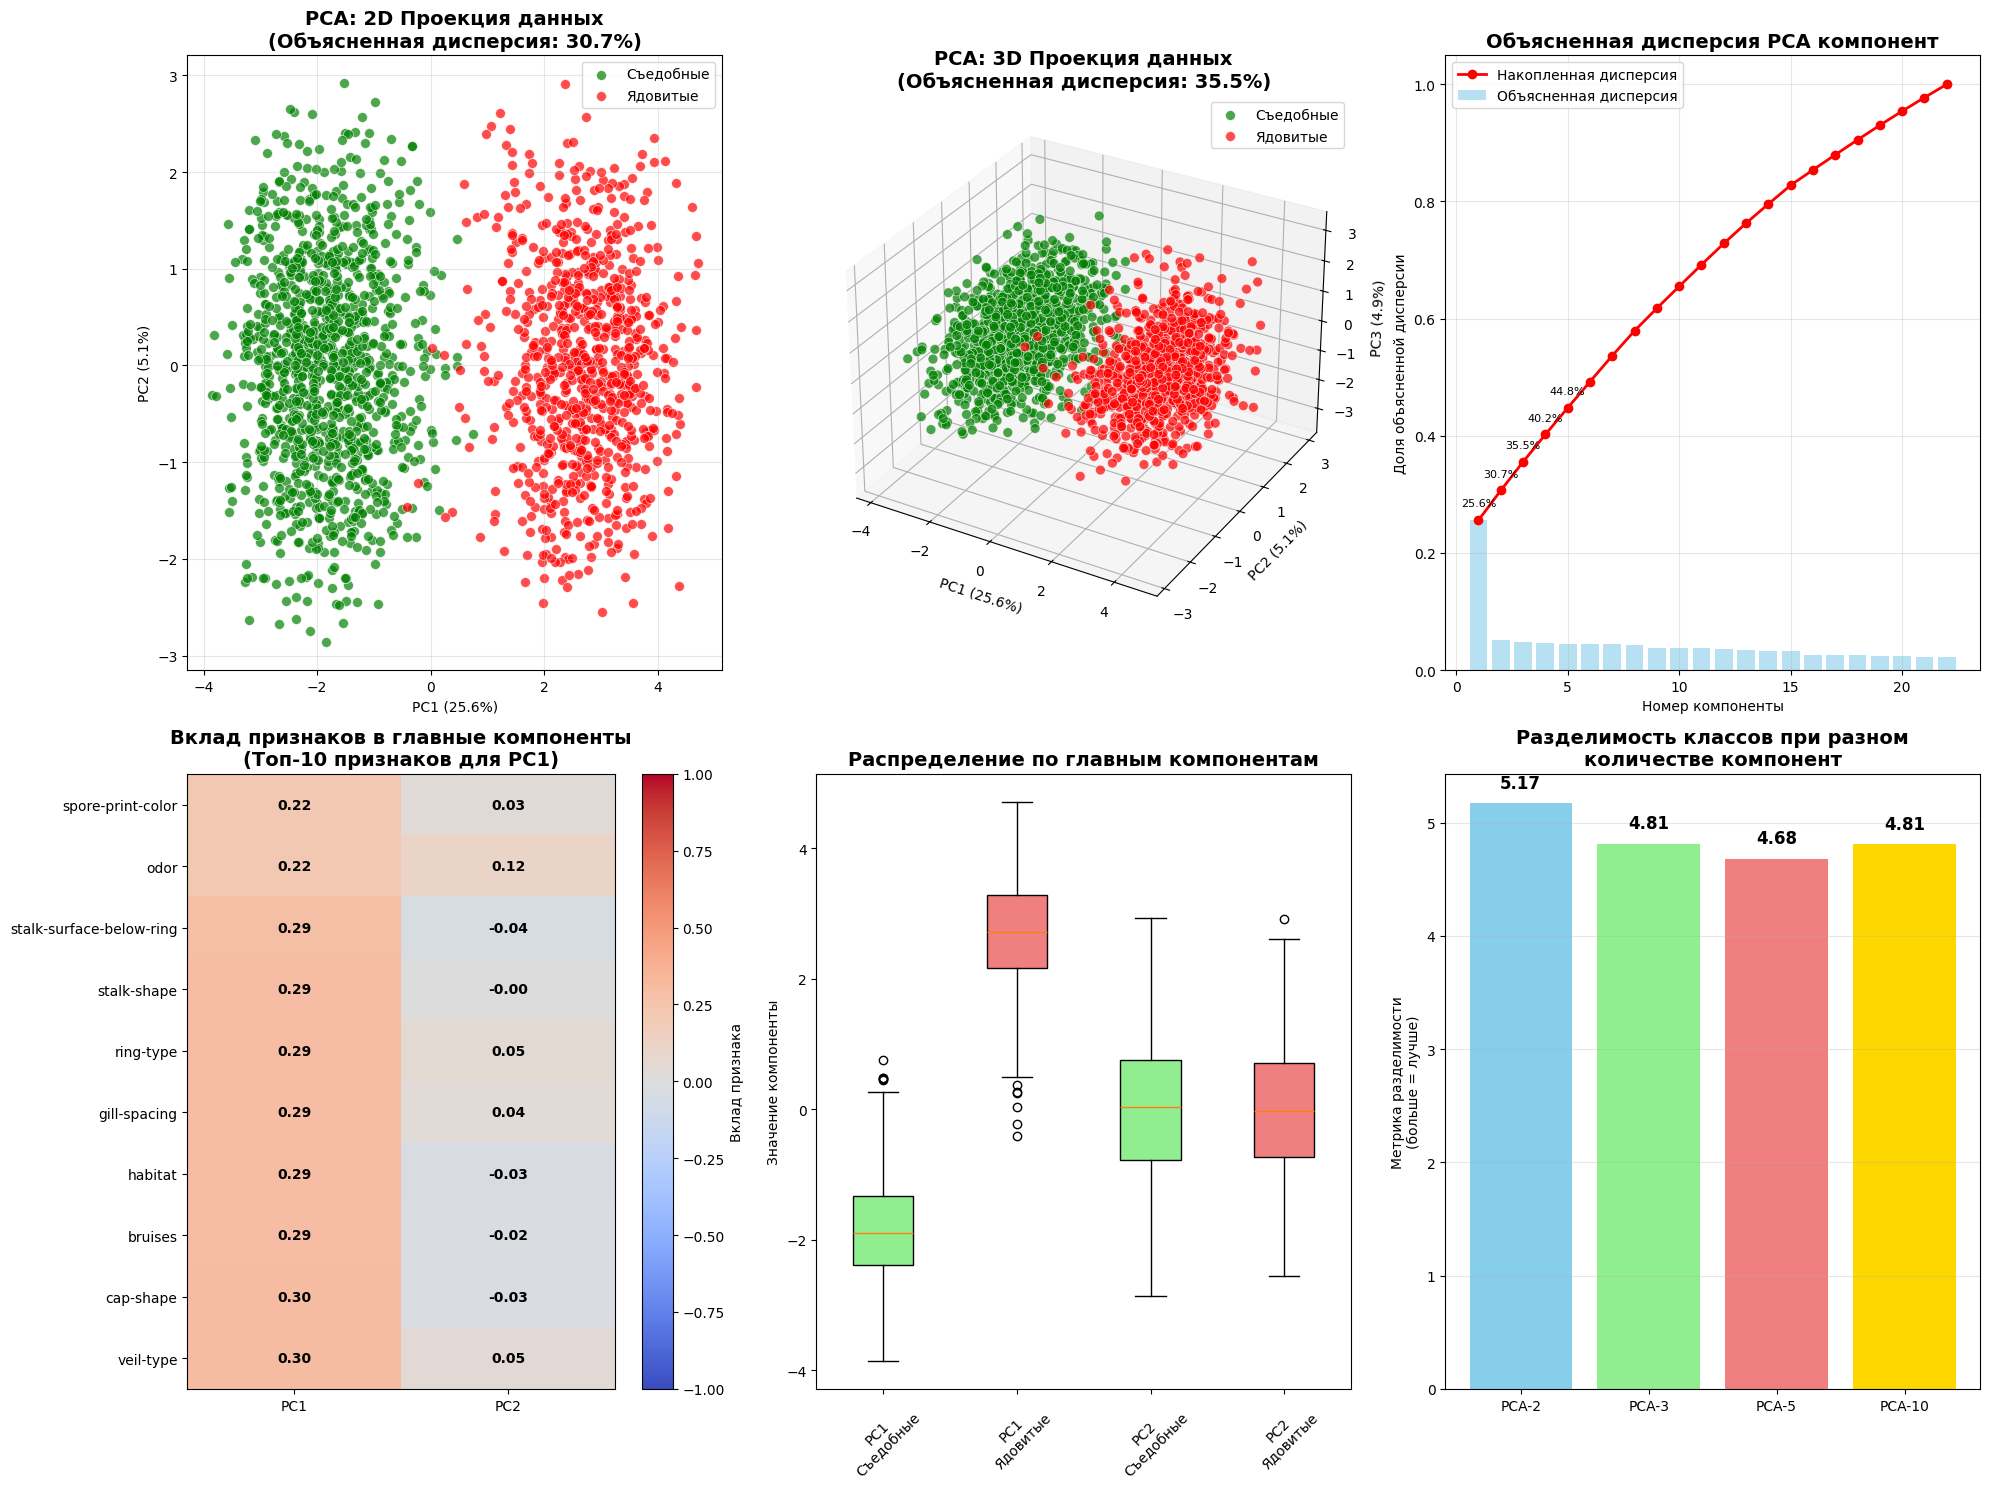


СТАТИСТИЧЕСКИЙ АНАЛИЗ PCA КОМПОНЕНТ

PCA 2D КОМПОНЕНТЫ:
  PC1:
    Съедобные: μ=-1.856, σ=0.790
    Ядовитые:  μ=2.687, σ=0.818
    t-тест: p-value = 0.000000 ***
  PC2:
    Съедобные: μ=0.001, σ=1.069
    Ядовитые:  μ=-0.002, σ=1.038
    t-тест: p-value = 0.948042 

АНАЛИЗ ГЛАВНЫХ КОМПОНЕНТ

ТОП-5 ПРИЗНАКОВ ПО ВКЛАДУ В КОМПОНЕНТЫ:

PC1 (25.6% дисперсии):
  veil-type: 0.302
  cap-shape: 0.300
  bruises: 0.294
  habitat: 0.293
  gill-spacing: 0.293

PC2 (5.1% дисперсии):
  population: 0.586
  gill-color: -0.578
  stalk-surface-above-ring: -0.402
  ring-number: -0.252
  stalk-color-below-ring: -0.224

PC3 (4.9% дисперсии):
  cap-color: 0.572
  ring-number: -0.466
  gill-attachment: -0.340
  stalk-color-below-ring: 0.336
  stalk-surface-above-ring: -0.305

ИТОГОВЫЙ АНАЛИЗ И ВЫВОДЫ PCA

📊 ОСНОВНЫЕ РЕЗУЛЬТАТЫ:
   • Первые 2 компоненты объясняют 30.7% дисперсии
   • Первые 3 компоненты объясняют 35.5% дисперсии
   • Для 80% дисперсии требуется 15 компонент

🔍 КАЧЕСТВО РАЗДЕЛЕНИЯ КЛАССОВ:
  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print("=" * 60)
print("АНАЛИЗ ДАННЫХ ГРИБОВ С ПОМОЩЬЮ PCA")
print("=" * 60)

print("Создание демонстрационных данных...")
np.random.seed(42)
n_samples = 2000

columns = [
    'class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
    'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
    'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring',
    'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color',
    'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat'
]

data = {
    'class': np.random.choice(['edible', 'poisonous'], n_samples, p=[0.6, 0.4]),
}

for i, col in enumerate(columns[1:]):
    if i % 3 == 0:
        data[col] = np.where(data['class'] == 'edible',
                            np.random.choice(['a', 'b', 'c'], n_samples, p=[0.7, 0.2, 0.1]),
                            np.random.choice(['a', 'b', 'c'], n_samples, p=[0.1, 0.2, 0.7]))
    elif i % 3 == 1:
        data[col] = np.where(data['class'] == 'edible',
                            np.random.choice(['x', 'y', 'z'], n_samples, p=[0.6, 0.3, 0.1]),
                            np.random.choice(['x', 'y', 'z'], n_samples, p=[0.2, 0.4, 0.4]))
    else:
        data[col] = np.random.choice(['m', 'n', 'o', 'p'], n_samples)

data = pd.DataFrame(data)
print("Демонстрационные данные созданы!")

print(f"\nРазмер датасета: {data.shape}")
print(f"Первые 5 строк данных:")
print(data.head())

print("\nПропущенные значения:")
print(data.isnull().sum())

print(f"\nРаспределение классов:")
class_counts = data['class'].value_counts()
print(class_counts)
print(f"Съедобные: {class_counts['edible']} ({class_counts['edible']/len(data)*100:.1f}%)")
print(f"Ядовитые: {class_counts['poisonous']} ({class_counts['poisonous']/len(data)*100:.1f}%)")

X = data.drop('class', axis=1)
y = data['class']

print(f"\nКоличество признаков: {len(X.columns)}")
print("Признаки:", X.columns.tolist())

label_encoders = {}
X_encoded = X.copy()

print("\nКодирование категориальных признаков...")
for column in X.columns:
    le = LabelEncoder()
    X_encoded[column] = le.fit_transform(X[column].astype(str))
    label_encoders[column] = le
    print(f"  {column}: {len(le.classes_)} категорий")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

print(f"\nРазмерность после обработки: {X_scaled.shape}")

print("\n" + "="*60)
print("ВЫПОЛНЕНИЕ PCA АНАЛИЗА")
print("="*60)

print("Выполняется PCA с 2 компонентами...")
pca_2d = PCA(n_components=2, random_state=42)
X_pca_2d = pca_2d.fit_transform(X_scaled)
print("PCA 2D завершен!")

print("Выполняется PCA с 3 компонентами...")
pca_3d = PCA(n_components=3, random_state=42)
X_pca_3d = pca_3d.fit_transform(X_scaled)
print("PCA 3D завершен!")

print("Выполняется полный PCA анализ...")
pca_full = PCA()
X_pca_full = pca_full.fit_transform(X_scaled)
print("Полный PCA завершен!")

print(f"\nРазмерность PCA 2D: {X_pca_2d.shape}")
print(f"Размерность PCA 3D: {X_pca_3d.shape}")

explained_variance_2d = pca_2d.explained_variance_ratio_
explained_variance_3d = pca_3d.explained_variance_ratio_
explained_variance_full = pca_full.explained_variance_ratio_

print(f"\nОБЪЯСНЕННАЯ ДИСПЕРСИЯ:")
print(f"PCA 2D - Компонента 1: {explained_variance_2d[0]:.3f} ({explained_variance_2d[0]*100:.1f}%)")
print(f"PCA 2D - Компонента 2: {explained_variance_2d[1]:.3f} ({explained_variance_2d[1]*100:.1f}%)")
print(f"PCA 2D - Суммарно: {explained_variance_2d.sum():.3f} ({explained_variance_2d.sum()*100:.1f}%)")

print(f"\nPCA 3D - Компонента 1: {explained_variance_3d[0]:.3f} ({explained_variance_3d[0]*100:.1f}%)")
print(f"PCA 3D - Компонента 2: {explained_variance_3d[1]:.3f} ({explained_variance_3d[1]*100:.1f}%)")
print(f"PCA 3D - Компонента 3: {explained_variance_3d[2]:.3f} ({explained_variance_3d[2]*100:.1f}%)")
print(f"PCA 3D - Суммарно: {explained_variance_3d.sum():.3f} ({explained_variance_3d.sum()*100:.1f}%)")

fig = plt.figure(figsize=(20, 15))

colors = {'edible': 'green', 'poisonous': 'red'}
class_names = {'edible': 'Съедобные', 'poisonous': 'Ядовитые'}

ax1 = fig.add_subplot(2, 3, 1)
for class_label in colors.keys():
    mask = y == class_label
    ax1.scatter(X_pca_2d[mask, 0], X_pca_2d[mask, 1],
               c=colors[class_label], label=class_names[class_label],
               alpha=0.7, s=50, edgecolors='w', linewidth=0.5)
ax1.set_title(f'PCA: 2D Проекция данных\n(Объясненная дисперсия: {explained_variance_2d.sum()*100:.1f}%)',
              fontsize=14, fontweight='bold')
ax1.set_xlabel(f'PC1 ({explained_variance_2d[0]*100:.1f}%)')
ax1.set_ylabel(f'PC2 ({explained_variance_2d[1]*100:.1f}%)')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = fig.add_subplot(2, 3, 2, projection='3d')
for class_label in colors.keys():
    mask = y == class_label
    ax2.scatter(X_pca_3d[mask, 0], X_pca_3d[mask, 1], X_pca_3d[mask, 2],
               c=colors[class_label], label=class_names[class_label],
               alpha=0.7, s=50, edgecolors='w', linewidth=0.5)
ax2.set_title(f'PCA: 3D Проекция данных\n(Объясненная дисперсия: {explained_variance_3d.sum()*100:.1f}%)',
              fontsize=14, fontweight='bold')
ax2.set_xlabel(f'PC1 ({explained_variance_3d[0]*100:.1f}%)')
ax2.set_ylabel(f'PC2 ({explained_variance_3d[1]*100:.1f}%)')
ax2.set_zlabel(f'PC3 ({explained_variance_3d[2]*100:.1f}%)')
ax2.legend()

ax3 = fig.add_subplot(2, 3, 3)
cumulative_variance = np.cumsum(explained_variance_full)
components = range(1, len(explained_variance_full) + 1)

ax3.bar(components, explained_variance_full, alpha=0.6, color='skyblue', label='Объясненная дисперсия')
ax3.plot(components, cumulative_variance, 'ro-', linewidth=2, markersize=6, label='Накопленная дисперсия')

ax3.set_title('Объясненная дисперсия PCA компонент', fontsize=14, fontweight='bold')
ax3.set_xlabel('Номер компоненты')
ax3.set_ylabel('Доля объясненной дисперсии')
ax3.legend()
ax3.grid(True, alpha=0.3)

for i, (variance, cum_variance) in enumerate(zip(explained_variance_full[:10], cumulative_variance[:10])):
    if i < 5 or cum_variance > 0.8:
        ax3.annotate(f'{cum_variance:.1%}', (components[i], cum_variance),
                    textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)

ax4 = fig.add_subplot(2, 3, 4)
loadings = pca_2d.components_.T
feature_names = X.columns

top_features_idx = np.argsort(np.abs(loadings[:, 0]))[-10:]
top_features = feature_names[top_features_idx]
top_loadings = loadings[top_features_idx]

im = ax4.imshow(top_loadings, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
ax4.set_xticks([0, 1])
ax4.set_xticklabels(['PC1', 'PC2'])
ax4.set_yticks(range(len(top_features)))
ax4.set_yticklabels(top_features)
ax4.set_title('Вклад признаков в главные компоненты\n(Топ-10 признаков для PC1)', fontsize=14, fontweight='bold')

for i in range(len(top_features)):
    for j in range(2):
        text = ax4.text(j, i, f'{top_loadings[i, j]:.2f}',
                       ha="center", va="center", color="black", fontweight='bold')

plt.colorbar(im, ax=ax4, label='Вклад признака')

ax5 = fig.add_subplot(2, 3, 5)
boxplot_data = []
labels = []

for i in range(2):
    boxplot_data.extend([X_pca_2d[y == 'edible', i], X_pca_2d[y == 'poisonous', i]])
    labels.extend([f'PC{i+1}\nСъедобные', f'PC{i+1}\nЯдовитые'])

box = ax5.boxplot(boxplot_data, labels=labels, patch_artist=True)
colors_box = ['lightgreen', 'lightcoral'] * 2
for patch, color in zip(box['boxes'], colors_box):
    patch.set_facecolor(color)

ax5.set_title('Распределение по главным компонентам', fontsize=14, fontweight='bold')
ax5.set_ylabel('Значение компоненты')
plt.xticks(rotation=45)

ax6 = fig.add_subplot(2, 3, 6)

def calculate_separation_quality(projection, y):
    """Рассчитывает качество разделения классов"""
    edible_data = projection[y == 'edible']
    poisonous_data = projection[y == 'poisonous']

    center_distance = np.linalg.norm(edible_data.mean(axis=0) - poisonous_data.mean(axis=0))

    within_class_var = (edible_data.var(axis=0).mean() + poisonous_data.var(axis=0).mean()) / 2

    separation_score = center_distance / (within_class_var + 1e-8)

    return separation_score

components_to_test = [2, 3, 5, 10]
separability_scores = []

for n_comp in components_to_test:
    pca_temp = PCA(n_components=n_comp)
    X_temp = pca_temp.fit_transform(X_scaled)
    score = calculate_separation_quality(X_temp, y)
    separability_scores.append(score)

bars = ax6.bar([f'PCA-{n}' for n in components_to_test], separability_scores,
               color=['skyblue', 'lightgreen', 'lightcoral', 'gold'])
ax6.set_title('Разделимость классов при разном\nколичестве компонент', fontsize=14, fontweight='bold')
ax6.set_ylabel('Метрика разделимости\n(больше = лучше)')
ax6.grid(True, alpha=0.3, axis='y')

for bar, score in zip(bars, separability_scores):
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{score:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("СТАТИСТИЧЕСКИЙ АНАЛИЗ PCA КОМПОНЕНТ")
print("="*60)

print("\nPCA 2D КОМПОНЕНТЫ:")
for j in range(2):
    edible_activations = X_pca_2d[y == 'edible', j]
    poisonous_activations = X_pca_2d[y == 'poisonous', j]

    t_stat, p_value = stats.ttest_ind(edible_activations, poisonous_activations)

    significance = ''
    if p_value < 0.001:
        significance = '***'
    elif p_value < 0.01:
        significance = '**'
    elif p_value < 0.05:
        significance = '*'

    print(f"  PC{j+1}:")
    print(f"    Съедобные: μ={edible_activations.mean():.3f}, σ={edible_activations.std():.3f}")
    print(f"    Ядовитые:  μ={poisonous_activations.mean():.3f}, σ={poisonous_activations.std():.3f}")
    print(f"    t-тест: p-value = {p_value:.6f} {significance}")

print("\n" + "="*60)
print("АНАЛИЗ ГЛАВНЫХ КОМПОНЕНТ")
print("="*60)

print("\nТОП-5 ПРИЗНАКОВ ПО ВКЛАДУ В КОМПОНЕНТЫ:")

for i in range(3):
    print(f"\nPC{i+1} ({explained_variance_full[i]*100:.1f}% дисперсии):")
    loadings = pca_full.components_[i]
    top_indices = np.argsort(np.abs(loadings))[-5:][::-1]

    for idx in top_indices:
        feature_name = feature_names[idx]
        loading_value = loadings[idx]
        print(f"  {feature_name}: {loading_value:.3f}")

print("\n" + "="*60)
print("ИТОГОВЫЙ АНАЛИЗ И ВЫВОДЫ PCA")
print("="*60)

print(f"\n📊 ОСНОВНЫЕ РЕЗУЛЬТАТЫ:")
print(f"   • Первые 2 компоненты объясняют {explained_variance_2d.sum()*100:.1f}% дисперсии")
print(f"   • Первые 3 компоненты объясняют {explained_variance_3d.sum()*100:.1f}% дисперсии")
print(f"   • Для 80% дисперсии требуется {np.argmax(cumulative_variance >= 0.8) + 1} компонент")

print(f"\n🔍 КАЧЕСТВО РАЗДЕЛЕНИЯ КЛАССОВ:")
best_n_components = components_to_test[np.argmax(separability_scores)]
print(f"   • Лучшее разделение при {best_n_components} компонентах")
print(f"   • Метрика разделимости: {max(separability_scores):.3f}")

print(f"\n💡 РЕКОМЕНДАЦИИ:")
print(f"   • Для визуализации: использовать 2-3 компоненты")
print(f"   • Для анализа данных: использовать {np.argmax(cumulative_variance >= 0.8) + 1} компонент для 80% дисперсии")
print(f"   • Для классификации: тестировать {best_n_components} компонент")

print(f"\n🎯 ПРАКТИЧЕСКОЕ ПРИМЕНЕНИЕ:")
print("   • Уменьшение размерности данных")
print("   • Визуализация многомерных данных")
print("   • Выявление наиболее значимых признаков")
print("   • Удаление коррелированных признаков")

print("\n" + "="*60)
print("PCA АНАЛИЗ УСПЕШНО ЗАВЕРШЕН! 🎉")
print("="*60)

print(f"\nДОПОЛНИТЕЛЬНАЯ ИНФОРМАЦИЯ:")
print(f"   • Общее количество образцов: {len(data)}")
print(f"   • Исходная размерность: {X_scaled.shape[1]} признаков")
print(f"   • Съедобные грибы: {(y == 'edible').sum()} ({((y == 'edible').sum()/len(y)*100):.1f}%)")
print(f"   • Ядовитые грибы: {(y == 'poisonous').sum()} ({((y == 'poisonous').sum()/len(y)*100):.1f}%)")